<a href="https://colab.research.google.com/github/Only-Space/gestur-tangan-huruf/blob/main/gestur_tangan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
import os
import zipfile

# Path ZIP dan lokasi ekstraksi
zip_path = "/content/drive/MyDrive/dataset/bisindo/dataset-bisindo-22k.zip"
extract_path = "/content/dataset"

# Ekstraksi jika folder belum ada
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak ke:", extract_path)


Dataset berhasil diekstrak ke: /content/dataset


In [6]:
# Label mapping termasuk huruf Z
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
    'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
    'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24,
    'Z': 25
}

inv_label_mapping = {v: k for k, v in label_mapping.items()}

RANDOM_SEED = 21
PATH_DATASET = "/content/dataset/bisindo"


In [7]:
from torchvision import transforms

# Nilai mean & std dataset
DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Transformasi training dengan augmentasi
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Transformasi validasi (tanpa augmentasi)
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Corrected paths - assuming images and labels are directly under train and val directories
PATH_TRAIN_IMG = os.path.join(PATH_DATASET, "images/train")
PATH_VAL_IMG = os.path.join(PATH_DATASET, "images/val")

PATH_TRAIN_LABEL = os.path.join(PATH_DATASET, "images/train") # Assuming labels are in the same directories as images
PATH_VAL_LABEL = os.path.join(PATH_DATASET, "images/val")   # Assuming labels are in the same directories as images

class BISINDODataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir # This might not be needed if labels are inferred from image paths
        self.transform = transform
        self.data = []

        # Modify to iterate through class folders directly under img_dir
        for class_name in sorted(os.listdir(img_dir)):
            class_img_path = os.path.join(img_dir, class_name)
            # Assuming label_dir is the same structure, can infer label from class_name
            if os.path.isdir(class_img_path) and class_name in label_mapping: # Check if it's a directory and a valid label
                 for img_file in os.listdir(class_img_path):
                    img_path = os.path.join(class_img_path, img_file)
                    # Assuming label is the class_name
                    self.data.append((img_path, label_mapping[class_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # Convert to RGB to ensure 3 channels consistently before Grayscale transform
        image = Image.open(img_path).convert("RGB")


        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = BISINDODataset(PATH_TRAIN_IMG, PATH_TRAIN_LABEL, transform=train_transform)
val_dataset = BISINDODataset(PATH_VAL_IMG, PATH_VAL_LABEL, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total data train: {len(train_dataset)}")
print(f"Total data val: {len(val_dataset)}")

Total data train: 9169
Total data val: 2301


In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Changed input channels to 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )

        # Calculate the correct input size for the linear layer
        # Based on 28x28 input and three MaxPool2d layers with kernel_size=2, stride=2
        # 28 -> 14 -> 7 -> 3
        flattened_size = 128 * 3 * 3

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [14]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs, device, patience=7):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer dengan weight_decay
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Early Stopping setup
    best_val_loss = np.inf
    patience_counter = 0
    best_model_path = "best_model.pth"

    print("🚀 Memulai proses training...")
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Validation Phase
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()

        # Hitung metrik rata-rata
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / len(train_loader.dataset)
        val_acc = 100 * val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Val loss membaik! Model terbaik disimpan di '{best_model_path}'")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⚠️ Val loss tidak membaik. Counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"🛑 Early stopping terpicu di Epoch {epoch+1}. Training dihentikan.")
            break

    print("🏁 Training selesai.")
    model.load_state_dict(torch.load(best_model_path))
    return model


In [ ]:
!nvidia-smi

In [34]:
model = CNN(num_classes=26)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")
model.to(device)

checkpoint_path = "best_model.pth"

# Cek apakah checkpoint ada
if os.path.exists(checkpoint_path):
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"✅ Bobot dari checkpoint '{checkpoint_path}' berhasil dimuat.")
        start_epoch = 0  # Atur jika menyimpan epoch juga
    except Exception as e:
        print(f"❌ Gagal memuat checkpoint: {e}")
        start_epoch = 0
else:
    print(f"❌ Checkpoint '{checkpoint_path}' tidak ditemukan. Training dari awal.")
    start_epoch = 0


# -----------------------------
# 5. Training Lanjutan
# -----------------------------
epochs = 45
print(f"Melanjutkan pelatihan selama {epochs} epoch...")
train_model(model, train_loader, val_loader, epochs, device) # Removed start_epoch

# Simpan Model Final
torch.save(model.state_dict(), "cnn_handsign_model_final.pth")
print("\n🎉 Pelatihan selesai! Model final diperbarui.")

Menggunakan device: cuda:0
❌ Checkpoint 'best_model.pth' tidak ditemukan. Training dari awal.
Melanjutkan pelatihan selama 45 epoch...
🚀 Memulai proses training...


Epoch 1/45 | Train Acc: 15.35% | Val Acc: 47.07% | Train Loss: 2.8775 | Val Loss: 1.8722
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 2/45 | Train Acc: 35.48% | Val Acc: 68.23% | Train Loss: 2.1012 | Val Loss: 1.2520
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 3/45 | Train Acc: 46.67% | Val Acc: 73.53% | Train Loss: 1.7535 | Val Loss: 1.0685
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 4/45 | Train Acc: 53.08% | Val Acc: 74.40% | Train Loss: 1.5624 | Val Loss: 0.9232
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 5/45 | Train Acc: 57.56% | Val Acc: 75.66% | Train Loss: 1.4246 | Val Loss: 0.8704
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 6/45 | Train Acc: 60.99% | Val Acc: 76.71% | Train Loss: 1.3214 | Val Loss: 0.8106
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 7/45 | Train Acc: 62.89% | Val Acc: 77.23% | Train Loss: 1.2586 | Val Loss: 0.7847
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 8/45 | Train Acc: 64.18% | Val Acc: 77.27% | Train Loss: 1.2049 | Val Loss: 0.7615
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 9/45 | Train Acc: 65.18% | Val Acc: 77.84% | Train Loss: 1.1726 | Val Loss: 0.7517
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 10/45 | Train Acc: 66.95% | Val Acc: 77.53% | Train Loss: 1.1078 | Val Loss: 0.7251
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 11/45 | Train Acc: 67.77% | Val Acc: 77.66% | Train Loss: 1.0939 | Val Loss: 0.7221
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 12/45 | Train Acc: 68.19% | Val Acc: 78.79% | Train Loss: 1.0659 | Val Loss: 0.6953
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 13/45 | Train Acc: 68.60% | Val Acc: 79.27% | Train Loss: 1.0373 | Val Loss: 0.6703
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 14/45 | Train Acc: 69.59% | Val Acc: 78.97% | Train Loss: 1.0225 | Val Loss: 0.6563
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 15/45 | Train Acc: 70.93% | Val Acc: 80.53% | Train Loss: 0.9803 | Val Loss: 0.6542
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 16/45 | Train Acc: 70.30% | Val Acc: 81.31% | Train Loss: 0.9961 | Val Loss: 0.6285
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 17/45 | Train Acc: 70.96% | Val Acc: 81.18% | Train Loss: 0.9719 | Val Loss: 0.6167
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 18/45 | Train Acc: 72.13% | Val Acc: 81.66% | Train Loss: 0.9414 | Val Loss: 0.6080
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 19/45 | Train Acc: 71.89% | Val Acc: 81.96% | Train Loss: 0.9356 | Val Loss: 0.6038
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 20/45 | Train Acc: 72.51% | Val Acc: 81.83% | Train Loss: 0.9087 | Val Loss: 0.5784
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 21/45 | Train Acc: 73.13% | Val Acc: 81.88% | Train Loss: 0.8908 | Val Loss: 0.5691
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 22/45 | Train Acc: 72.80% | Val Acc: 83.36% | Train Loss: 0.9008 | Val Loss: 0.5497
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 23/45 | Train Acc: 74.14% | Val Acc: 82.36% | Train Loss: 0.8742 | Val Loss: 0.5576
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 24/45 | Train Acc: 74.14% | Val Acc: 83.88% | Train Loss: 0.8603 | Val Loss: 0.5341
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 25/45 | Train Acc: 74.42% | Val Acc: 82.92% | Train Loss: 0.8491 | Val Loss: 0.5360
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 26/45 | Train Acc: 74.42% | Val Acc: 83.92% | Train Loss: 0.8354 | Val Loss: 0.5126
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 27/45 | Train Acc: 74.68% | Val Acc: 82.83% | Train Loss: 0.8302 | Val Loss: 0.5331
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 28/45 | Train Acc: 74.89% | Val Acc: 83.79% | Train Loss: 0.8200 | Val Loss: 0.5243
⚠️ Val loss tidak membaik. Counter: 2/7


Epoch 29/45 | Train Acc: 75.44% | Val Acc: 84.31% | Train Loss: 0.8013 | Val Loss: 0.5107
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 30/45 | Train Acc: 76.30% | Val Acc: 84.09% | Train Loss: 0.7780 | Val Loss: 0.4971
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 31/45 | Train Acc: 75.79% | Val Acc: 84.75% | Train Loss: 0.7903 | Val Loss: 0.4784
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 32/45 | Train Acc: 76.30% | Val Acc: 84.79% | Train Loss: 0.7775 | Val Loss: 0.4769
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 33/45 | Train Acc: 76.34% | Val Acc: 85.57% | Train Loss: 0.7722 | Val Loss: 0.4738
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 34/45 | Train Acc: 76.89% | Val Acc: 86.01% | Train Loss: 0.7623 | Val Loss: 0.4622
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 35/45 | Train Acc: 76.81% | Val Acc: 85.35% | Train Loss: 0.7436 | Val Loss: 0.4759
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 36/45 | Train Acc: 77.28% | Val Acc: 85.53% | Train Loss: 0.7443 | Val Loss: 0.4663
⚠️ Val loss tidak membaik. Counter: 2/7


Epoch 37/45 | Train Acc: 77.30% | Val Acc: 85.01% | Train Loss: 0.7339 | Val Loss: 0.4707
⚠️ Val loss tidak membaik. Counter: 3/7


Epoch 38/45 | Train Acc: 77.29% | Val Acc: 86.66% | Train Loss: 0.7315 | Val Loss: 0.4479
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 39/45 | Train Acc: 78.00% | Val Acc: 85.96% | Train Loss: 0.7139 | Val Loss: 0.4326
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 40/45 | Train Acc: 78.36% | Val Acc: 86.74% | Train Loss: 0.6934 | Val Loss: 0.4220
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 41/45 | Train Acc: 79.10% | Val Acc: 86.66% | Train Loss: 0.6892 | Val Loss: 0.4179
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 42/45 | Train Acc: 78.56% | Val Acc: 87.53% | Train Loss: 0.6971 | Val Loss: 0.4074
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 43/45 | Train Acc: 78.80% | Val Acc: 87.48% | Train Loss: 0.6719 | Val Loss: 0.3989
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 44/45 | Train Acc: 79.39% | Val Acc: 87.74% | Train Loss: 0.6568 | Val Loss: 0.3968
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 45/45 | Train Acc: 79.88% | Val Acc: 87.92% | Train Loss: 0.6605 | Val Loss: 0.3972
⚠️ Val loss tidak membaik. Counter: 1/7
🏁 Training selesai.

🎉 Pelatihan selesai! Model final diperbarui.


In [31]:
def evaluate(model, loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)

            correct += (preds == labels).sum().item()
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_samples

In [32]:
import os
import pandas as pd
from torch.utils.data import DataLoader

# Try lowercase 'test' first
PATH_TEST = os.path.join(PATH_DATASET, "images/val")

# If lowercase 'test' doesn't exist, try uppercase 'Test' (though less likely based on previous errors)
if not os.path.exists(PATH_TEST):
    PATH_TEST = os.path.join(PATH_DATASET, "images/val")

print(f"Attempting to load test data from: {PATH_TEST}")

# Define LABELS from the keys of label_mapping
LABELS = list(label_mapping.keys())

data_test = []
if os.path.exists(PATH_TEST):
    for label in LABELS:
        label_path = os.path.join(PATH_TEST, label)
        if not os.path.exists(label_path):
            print(f"Warning: {label_path} tidak ditemukan, dilewati.")
            continue
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data_test.append({
                    "label": label,  # Simpan string label
                    "full_path": full_path
                })
else:
    print(f"Error: Test data directory not found at {PATH_TEST}")


df_test = pd.DataFrame(data_test)

# Only create DataLoader if test data was found
if len(df_test) > 0:
    test_loader = DataLoader(
        BISINDODataset(PATH_TEST, PATH_TEST, val_transform), # Use BISINDODataset and correct paths
        batch_size=64,
        shuffle=False
    )
    print(f"Total data test: {len(df_test)}")
else:
    print("No test data found. Cannot create test_loader.")

Attempting to load test data from: /content/dataset/bisindo/images/val
Total data test: 2301


Evaluating: 100%|██████████| 36/36 [00:10<00:00,  3.42it/s]

Accuracy: 88.70%
260


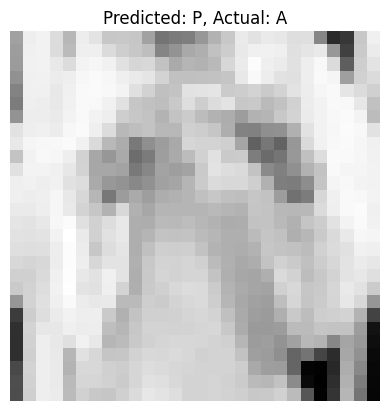

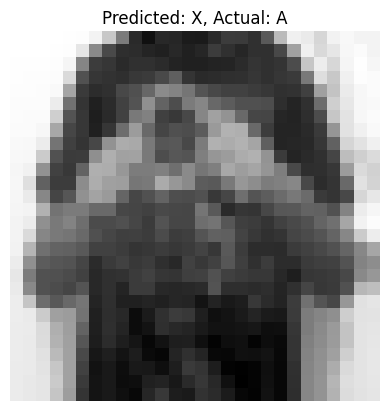

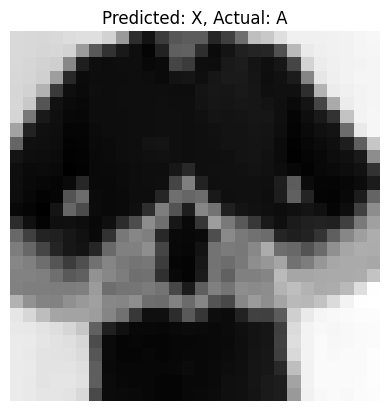

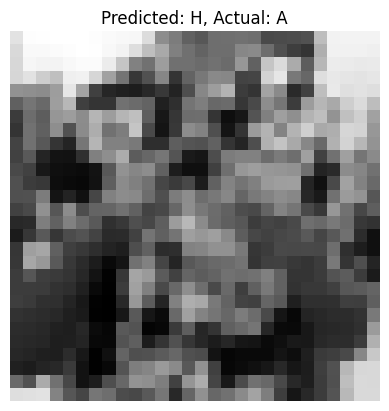

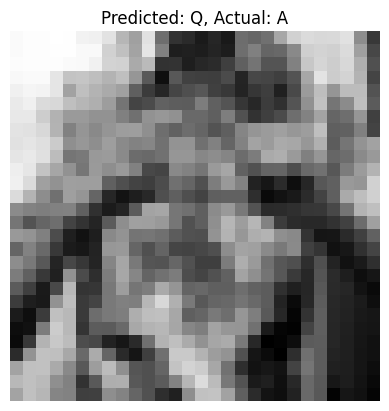

In [33]:
incorrect = evaluate(model, test_loader)

print(len(incorrect))
for i in range(min(5, len(incorrect))):
    img, pred, label = incorrect[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted: {inv_label_mapping[pred.item()]}, Actual: {inv_label_mapping[label.item()]}")
    plt.axis('off')
    plt.show()